<a href="https://colab.research.google.com/github/alexndremelyanov/_/blob/main/L3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
!pip install category_encoders | grep -v 'already satisfied'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.utils import resample
from sklearn.metrics import f1_score

In [27]:
inclass_csv = pd.read_csv("insclass_train.csv")

inclass_attributes = inclass_csv.drop('target', axis=1)
target = inclass_csv['target']

train_data, test_data, train_target, test_target = train_test_split(
  inclass_attributes,
  target,
  test_size=0.25,
  stratify=target,
  random_state=50
)

encoder = TargetEncoder(cols=["variable_1",
                              "variable_5",
                              "variable_20",
                              "variable_21",
                              "variable_22",
                              "variable_28"]).fit(train_data, train_target)

encoder.transform(train_data)
train_data = encoder.transform(train_data)
test_data = encoder.transform(test_data)

train_data = train_data.drop(["variable_7", "variable_9", "variable_15", 'variable_3'], axis=1)
test_data = test_data.drop(["variable_7", "variable_9", "variable_15", 'variable_3'], axis=1)
columns = train_data.select_dtypes(include='number').columns

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(train_data[columns])

train_data[columns] = imputer.transform(train_data[columns])
test_data[columns] = imputer.transform(test_data[columns])

scaler = MinMaxScaler()

scaler.fit(train_data[columns])

train_data[columns] = scaler.transform(train_data[columns])
test_data[columns] = scaler.transform(test_data[columns])

train_data["variable_0"] = np.ones((train_data.shape[0]))
test_data["variable_0"] = np.ones((test_data.shape[0]))

columns = train_data.select_dtypes(include='number').columns

train_target = np.array(train_target).reshape(-1, 1)
test_target = np.array(test_target).reshape(-1, 1)

In [28]:
class Regression:
    def __init__(self, threshold = 0.5):
        self.a = np.zeros(2).reshape(1, 2)
        self.threshold = threshold

    def sigmoid(self, x):
        return 1/(1 + np.exp(-x @ self.a))

    def predict_probability(self, x):
        return self.sigmoid(x)

    def predict(self, x):
        return (self.predict_probability(x) > self.threshold).astype(int)

    def coefs(self):
        return self.a

    def log_likelihood(self, x, Y):
        return (Y * np.log(self.predict_probability(x) + 1e-7) + (1 - Y) * np.log(1 + 1e-7 - self.predict_probability(x))).mean()

    def cross_entropy(self, x, Y):
        return (-Y * np.log(self.predict_probability(x)) - (1 - Y) * np.log(1 - self.predict_probability(x))).mean()

    def accuracy(self, x, Y):
        return (self.predict(x) == Y).mean()

    def fit(self, x, Y, alpha = 0.01, epsylon = 0.01, max_steps = 1000, Rtype = "LL"):
        self.a = np.zeros(x.shape[1]).reshape(x.shape[1],1)
        steps, errors = [], []
        step, new_error = 0,0
        for _ in range(max_steps):
            if Rtype == "LL":
                new_error = self.log_likelihood(x, Y)
                dT_a = x.T @ (Y - self.predict_probability(x)) / x.shape[0]
                self.a += alpha * dT_a

            elif Rtype == "CE":
                new_error = self.cross_entropy(x, Y)
                dT_a = -x.T @ (Y - self.predict_probability(x)) / x.shape[0]
                self.a -= alpha*dT_a
            step += 1
            steps.append(step)
            errors.append(new_error)

        return steps, errors

In [35]:
ALPHA = 0.01
ESPYLON = 0.01
MAX_STEPS = 500
THRESHOLD = 0.2
regression = Regression(threshold=THRESHOLD)

In [36]:
ll_steps , ll_errors = regression.fit(train_data[columns], train_target, alpha=ALPHA,epsylon=ESPYLON,max_steps=MAX_STEPS,Rtype="LL")
accuracy = regression.accuracy(test_data[columns], test_target)[0]

print(f"Точность метода градиентного подъема (LL): {accuracy}")

Точность метода градиентного подъема (LL): 0.9039680862305822


In [37]:
ce_steps, ce_errors = regression.fit(train_data[columns], train_target, alpha=ALPHA,epsylon=ESPYLON,max_steps=MAX_STEPS,Rtype="CE")
accuracy = regression.accuracy(test_data[columns], test_target)[0]

print(f"Точность метода градиентного спуска (CE): {accuracy}")

Точность метода градиентного спуска (CE): 0.9039680862305822


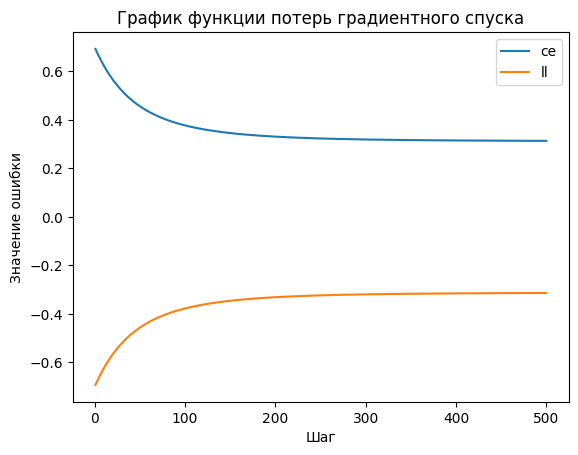

In [38]:
fig = plt.figure()

ax = fig.add_subplot()


ax.plot(ce_steps, ce_errors, label='ce')

ax.plot(ll_steps, ll_errors, label='ll')
handles, titles = ax.get_legend_handles_labels()

ax.set_xlabel('Шаг')
ax.set_title('График функции потерь градиентного спуска')
ax.set_ylabel('Значение ошибки')
_ = ax.legend(handles, titles)

In [33]:

f1 = f1_score(train_target, regression.predict(train_data))
print(f"F1 Score train: {f1}")
f1 = f1_score(test_target, regression.predict(test_data))
print(f"F1 Score test: {f1}")

F1 Score train: 0.0003676808530195791
F1 Score test: 0.0


Accuracy on train (LL_train_oversampled): 0.5946256450199591
Accuracy on test (LL_test_oversampled): 0.5858866138972457
Accuracy on train (CE_train_oversampled): 0.5946256450199591
Accuracy on test (CE_test_oversampled): 0.5858866138972457


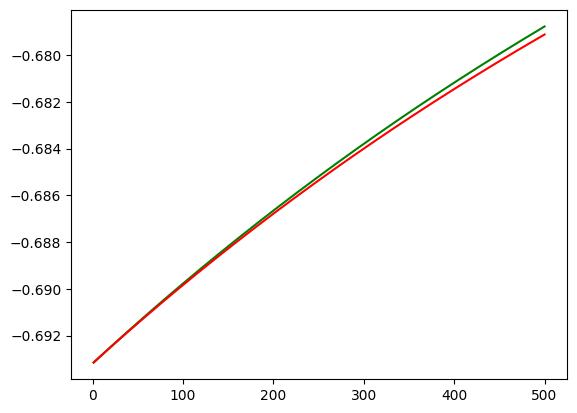

In [46]:

minority_oversample = resample(
    train_data[train_target == 1],
    replace=True,
    n_samples=len(train_target[train_target == 0]),
    random_state=73
)
minority_oversample = minority_oversample.reset_index(drop=True)
attributes_train_oversampled = pd.concat([train_data[train_target == 0], minority_oversample]).reset_index(drop=True)
target_train_oversampled = np.array([np.zeros(len(train_target[train_target == 0])), np.ones(len(minority_oversample))]).reshape(-1, 1)

minority_oversample_test = resample(
    test_data[test_target == 1],
    replace=True,
    n_samples=len(test_target[test_target == 0]),
    random_state=42
)
minority_oversample_test = minority_oversample_test.reset_index(drop=True)
attributes_test_oversampled = pd.concat([test_data[test_target == 0], minority_oversample_test]).reset_index(drop=True)
target_test_oversampled = np.array([np.zeros(len(test_target[test_target == 0])), np.ones(len(minority_oversample_test))]).reshape(-1, 1)

model = Regression()

steps_LL, errors_LL = model.fit(attributes_train_oversampled,target_train_oversampled,alpha=0.01,epsylon=0.01,max_steps=500,Rtype="LL")
steps_LL2, errors_LL2 = model.fit(attributes_test_oversampled,target_test_oversampled,alpha=0.01,epsylon=0.01,max_steps=500,Rtype="LL")


steps_CE, errors_CE = model.fit(attributes_train_oversampled,target_train_oversampled,alpha=0.01,epsylon=0.01,max_steps=500,Rtype="CE")
print(f"Accuracy on train (LL_train_oversampled): {model.accuracy(attributes_train_oversampled, target_train_oversampled)[0]}")
print(f"Accuracy on test (LL_test_oversampled): {model.accuracy(attributes_test_oversampled, target_test_oversampled)[0]}")
print(f"Accuracy on train (CE_train_oversampled): {model.accuracy(attributes_train_oversampled, target_train_oversampled)[0]}")
print(f"Accuracy on test (CE_test_oversampled): {model.accuracy(attributes_test_oversampled, target_test_oversampled)[0]}")
_ =plt.plot(steps_LL, errors_LL, 'g')
_ =plt.plot(steps_LL2, errors_LL2, 'r')

In [47]:
f1 = f1_score(target_train_oversampled, model.predict(attributes_train_oversampled))
print(f"F1 Score train: {f1}")
f1 = f1_score(target_test_oversampled, model.predict(attributes_test_oversampled))
print(f"F1 Score test: {f1}")

F1 Score train: 0.49058519814518003
F1 Score test: 0.4748305367263029


In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import DataConversionWarning
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


models = {
    'L1': LogisticRegression(penalty='l1', solver='liblinear'),
    'L2': LogisticRegression(penalty='l2'),
    'ElasticNet': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)
}


results = {}
for name, model in models.items():
    model.fit(attributes_train_oversampled, target_train_oversampled)
    f1_train = f1_score(target_train_oversampled, model.predict(attributes_train_oversampled))
    accuracy_train = model.score(attributes_train_oversampled, target_train_oversampled)
    f1_test = f1_score(target_test_oversampled, model.predict(attributes_test_oversampled))
    accuracy_test = model.score(attributes_test_oversampled, target_test_oversampled)
    results[f'f1_{name}_train'] = f1_train
    results[f'Accuracy_{name}_train'] = accuracy_train
    results[f'f1_{name}_test'] = f1_test
    results[f'Accuracy_{name}_test'] = accuracy_test

# Вывод результатов
for key, value in results.items():
    print(f"{key}: {value}")

f1_L1_train: 0.6006625069011137
Accuracy_L1_train: 0.6267549410962905
f1_L1_test: 0.5872474251120371
Accuracy_L1_test: 0.6166574174139089
f1_L2_train: 0.6007458799508303
Accuracy_L2_train: 0.6268523025995522
f1_L2_test: 0.5871784787225675
Accuracy_L2_test: 0.6167742500803225
f1_ElasticNet_train: 0.6005719435140667
Accuracy_ElasticNet_train: 0.6267111284198228
f1_ElasticNet_test: 0.5871363421921686
Accuracy_ElasticNet_test: 0.6165843969974004


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_scores = []

for C_val in C_values:
    model = LogisticRegression(solver='liblinear', C=C_val, penalty='l2')
    scores = cross_val_score(model,attributes_test_oversampled,target_test_oversampled, cv=5, scoring='accuracy')
    cv_scores.append(np.mean(scores))

optimal_C = C_values[np.argmax(cv_scores)]

print("Оптимальное значение C (лямбда):", optimal_C)

Оптимальное значение C (лямбда): 10


In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
performance_results = {'C': [], 'train_accuracy': [], 'test_accuracy': []}

for C_val in C_values:
    model = LogisticRegression(solver='liblinear', C=C_val, penalty='l2')
    model.fit(attributes_train_oversampled, target_train_oversampled)
    train_accuracy = model.score(attributes_train_oversampled, target_train_oversampled)
    test_accuracy = model.score(attributes_test_oversampled, target_test_oversampled)
    performance_results['C'].append(C_val)
    performance_results['train_accuracy'].append(train_accuracy)
    performance_results['test_accuracy'].append(test_accuracy)

for i in range(len(C_values)):
    print(f"C: {performance_results['C'][i]}, Train Accuracy: {performance_results['train_accuracy'][i]}, Test Accuracy: {performance_results['test_accuracy'][i]}")

C: 0.001, Train Accuracy: 0.6221546100671794, Test Accuracy: 0.614101702836113
C: 0.01, Train Accuracy: 0.6272855612890663, Test Accuracy: 0.616087858165143
C: 0.1, Train Accuracy: 0.627027553305423, Test Accuracy: 0.6164529602476853
C: 1, Train Accuracy: 0.6268279622237367, Test Accuracy: 0.6168764786634343
C: 10, Train Accuracy: 0.6265845584655827, Test Accuracy: 0.6171393521628648
C: 100, Train Accuracy: 0.626599162691072, Test Accuracy: 0.6171831644127698
C: 1000, Train Accuracy: 0.626599162691072, Test Accuracy: 0.6171831644127698


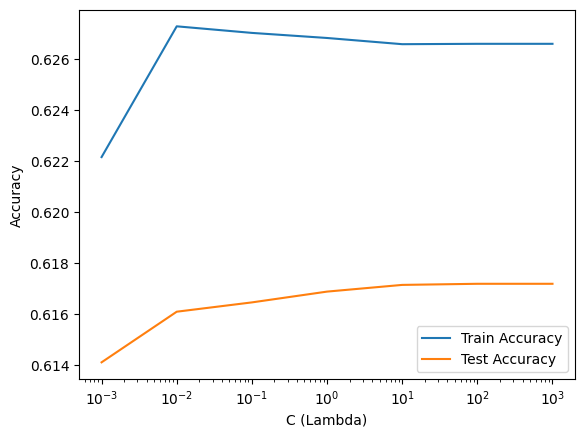

In [57]:
import matplotlib.pyplot as plt

C_values = performance_results['C']
train_accuracy = performance_results['train_accuracy']
test_accuracy = performance_results['test_accuracy']

plt.plot(C_values, train_accuracy, label='Train Accuracy')
plt.plot(C_values, test_accuracy, label='Test Accuracy')
plt.xscale('log')
plt.xlabel('C (Lambda)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_scores = []

for C_val in C_values:
    model = LogisticRegression(solver='liblinear', C=C_val, penalty='l1')
    scores = cross_val_score(model,attributes_test_oversampled,target_test_oversampled, cv=5, scoring='accuracy')
    cv_scores.append(np.mean(scores))

optimal_C = C_values[np.argmax(cv_scores)]

print("Оптимальное значение C (лямбда):", optimal_C)

Оптимальное значение C (лямбда): 0.1


In [64]:
C_values = [0.01, 0.1, 1, 10]
performance_results = {'C': [], 'train_accuracy': [], 'test_accuracy': []}

for C_val in C_values:
    model = LogisticRegression(solver='liblinear', C=C_val, penalty='l1')
    model.fit(attributes_train_oversampled, target_train_oversampled)
    train_accuracy = model.score(attributes_train_oversampled, target_train_oversampled)
    test_accuracy = model.score(attributes_test_oversampled, target_test_oversampled)
    performance_results['C'].append(C_val)
    performance_results['train_accuracy'].append(train_accuracy)
    performance_results['test_accuracy'].append(test_accuracy)

for i in range(len(C_values)):
    print(f"C: {performance_results['C'][i]}, Train Accuracy: {performance_results['train_accuracy'][i]}, Test Accuracy: {performance_results['test_accuracy'][i]}")

C: 0.01, Train Accuracy: 0.6268182260734105, Test Accuracy: 0.6166136051640039
C: 0.1, Train Accuracy: 0.6272563528380878, Test Accuracy: 0.6163361275812718
C: 1, Train Accuracy: 0.6267598091714536, Test Accuracy: 0.6166574174139089
C: 10, Train Accuracy: 0.626599162691072, Test Accuracy: 0.6171393521628648


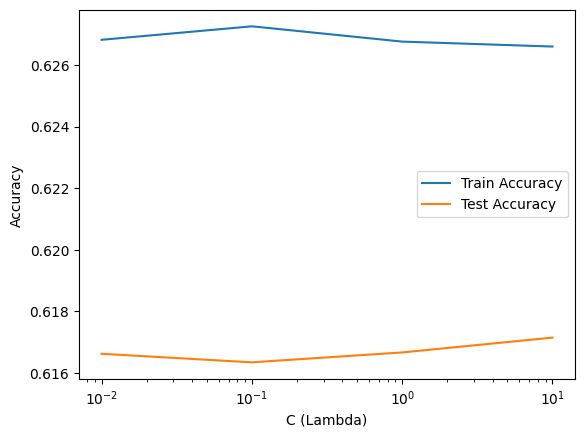

In [66]:
import matplotlib.pyplot as plt

C_values = performance_results['C']
train_accuracy = performance_results['train_accuracy']
test_accuracy = performance_results['test_accuracy']

plt.plot(C_values, train_accuracy, label='Train Accuracy')
plt.plot(C_values, test_accuracy, label='Test Accuracy')
plt.xscale('log')
plt.xlabel('C (Lambda)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

C_values = [0.01, 0.1, 1, 10]
cv_scores = []

for C_val in C_values:
    model = LogisticRegression(solver='saga', C=C_val, penalty='elasticnet',l1_ratio=0.5)
    scores = cross_val_score(model,attributes_test_oversampled,target_test_oversampled, cv=5, scoring='accuracy')
    cv_scores.append(np.mean(scores))

optimal_C = C_values[np.argmax(cv_scores)]

print("Оптимальное значение C (лямбда):", optimal_C)

Оптимальное значение C (лямбда): 0.1


In [68]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
performance_results = {'C': [], 'train_accuracy': [], 'test_accuracy': []}

for C_val in C_values:
    model = LogisticRegression(solver='saga', C=C_val, penalty='elasticnet',l1_ratio=0.5)
    model.fit(attributes_train_oversampled, target_train_oversampled)
    train_accuracy = model.score(attributes_train_oversampled, target_train_oversampled)
    test_accuracy = model.score(attributes_test_oversampled, target_test_oversampled)
    performance_results['C'].append(C_val)
    performance_results['train_accuracy'].append(train_accuracy)
    performance_results['test_accuracy'].append(test_accuracy)

for i in range(len(C_values)):
    print(f"C: {performance_results['C'][i]}, Train Accuracy: {performance_results['train_accuracy'][i]}, Test Accuracy: {performance_results['test_accuracy'][i]}")

C: 0.001, Train Accuracy: 0.6197400447862915, Test Accuracy: 0.6066828285188539
C: 0.01, Train Accuracy: 0.6273829227923279, Test Accuracy: 0.616847270496831
C: 0.1, Train Accuracy: 0.6267744133969428, Test Accuracy: 0.6167742500803225
C: 1, Train Accuracy: 0.6267111284198228, Test Accuracy: 0.6165843969974004
C: 10, Train Accuracy: 0.6265845584655827, Test Accuracy: 0.6171539562461664
C: 100, Train Accuracy: 0.626540745789115, Test Accuracy: 0.6171831644127698
C: 1000, Train Accuracy: 0.6265456138642781, Test Accuracy: 0.6171977684960716


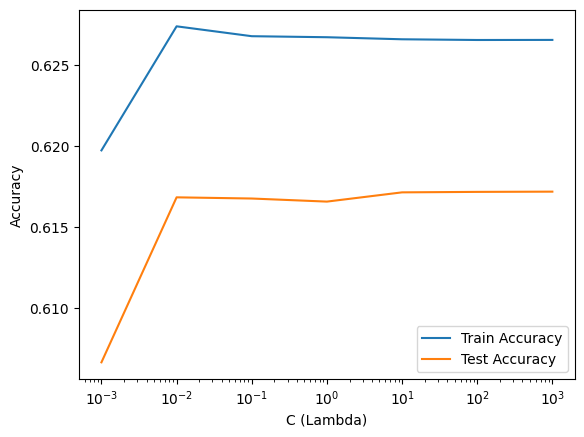

In [69]:
import matplotlib.pyplot as plt

C_values = performance_results['C']
train_accuracy = performance_results['train_accuracy']
test_accuracy = performance_results['test_accuracy']

plt.plot(C_values, train_accuracy, label='Train Accuracy')
plt.plot(C_values, test_accuracy, label='Test Accuracy')
plt.xscale('log')
plt.xlabel('C (Lambda)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [70]:
class LogisticRegressionGDReg:
    def __init__(self, threshold=0.5):
        self.a = np.zeros(2).reshape(1, 2)
        self.threshold = threshold
    def sigmoid(self, x):
        return 1/(1 + np.exp(-x @ self.a))
    def predict_proba(self, x):
        return self.sigmoid(x)
    def predict(self, x):
        return (self.predict_proba(x) > self.threshold).astype(int)
    def coefs(self):
        return self.a
    def LogLikelihood(self, x, Y):
        return (Y * np.log(self.predict_proba(x) + 1e-7) + (1 - Y) * np.log(1 + 1e-7 - self.predict_proba(x))).mean()
    def CrossEntropy(self, x, Y):
        return (-Y * np.log(self.predict_proba(x)) - (1 - Y) * np.log(1 - self.predict_proba(x))).mean()
    def accuracy(self, x, Y):
        return (self.predict(x) == Y).mean()
    def fit(self, x, Y, alpha = 0.01, epsylon = 0.01, max_steps = 1000, Rtype = "LL", intercept = True, reg = "No", lam = 0, rho = 0):
        self.a = np.zeros (x.shape[1]).reshape(x.shape[1],1)
        steps, errors = [], []
        step,new_error = 0,0

        for _ in range(max_steps):
            if Rtype == "LL":
                new_error = self.LogLikelihood(x, Y)
                dT_a = x.T @(Y - self.predict_proba(x)) / x.shape[0]
                if reg == "L1":
                  dT_a += lam*(np.sign(self.a))
                elif reg == "L2":
                  dT_a += 2*lam*((self.a))
                elif reg == "ElasticNet":
                  dT_a += rho*lam*(np.sign(self.a)) + 2*(1-rho)*lam*((self.a))
                self.a += alpha*dT_a
                step += 1
                steps.append(step)
                errors.append(new_error)
            elif Rtype == "CE":
                new_error = self.CrossEntropy(x, Y)
                #display(new_error)
                dT_a = -x.T @(Y - self.predict_proba(x)) / x.shape[0]
                self.a -= alpha*dT_a
        return steps, errors


model = LogisticRegressionGDReg()



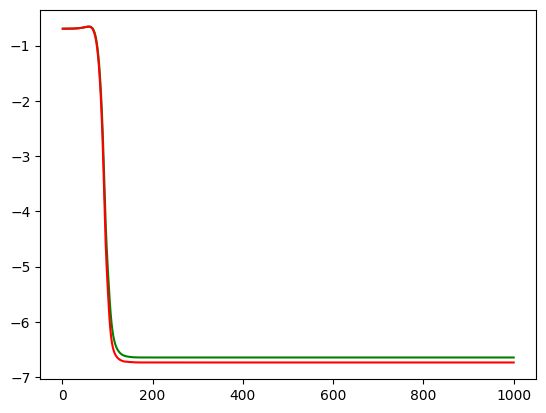

In [84]:
import warnings
warnings.filterwarnings('ignore')


steps_1, errors_1 = model.fit(attributes_train_oversampled,target_train_oversampled,alpha=0.01,epsylon=0.01,max_steps=1000,Rtype="LL", intercept = True, reg = "L2", lam = 5, rho = 0)
steps_2, errors_2 = model.fit(attributes_test_oversampled,target_test_oversampled,alpha=0.01,epsylon=0.01,max_steps=1000,Rtype="LL", intercept = True, reg = "L2", lam = 5, rho = 0)

plt.plot(steps_1, errors_1, 'g')
plt.plot(steps_2, errors_2, 'r')

In [85]:
acc_train= model.accuracy(attributes_train_oversampled,target_train_oversampled)
acc_test= model.accuracy(attributes_test_oversampled,target_test_oversampled)
print("train:",acc_train)
print("test:",acc_test)
print(errors_1[1],errors_1[-1])

train: 0    0.583142
dtype: float64
test: 0    0.582177
dtype: float64
0   -0.693111
dtype: float64 0   -6.644183
dtype: float64


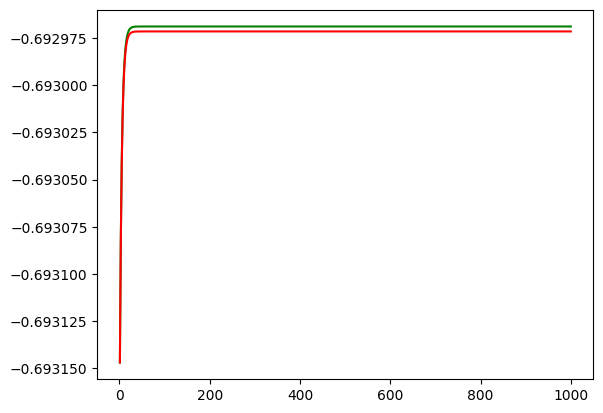

In [73]:
steps_1, errors_1 = model.fit(attributes_train_oversampled,target_train_oversampled,alpha=0.01,epsylon=0.01,max_steps=1000,Rtype="LL", intercept = True, reg = "L2", lam = -10, rho = 0)
steps_2, errors_2 = model.fit(attributes_test_oversampled,target_test_oversampled,alpha=0.01,epsylon=0.01,max_steps=1000,Rtype="LL", intercept = True, reg = "L2", lam = -10, rho = 0)

plt.plot(steps_1, errors_1, 'g')
plt.plot(steps_2, errors_2, 'r')

In [74]:
acc_train= model.accuracy(attributes_train_oversampled,target_train_oversampled)
acc_test= model.accuracy(attributes_test_oversampled,target_test_oversampled)
print("train:",acc_train)
print("test:",acc_test)

train: 0    0.572398
dtype: float64
test: 0    0.57286
dtype: float64


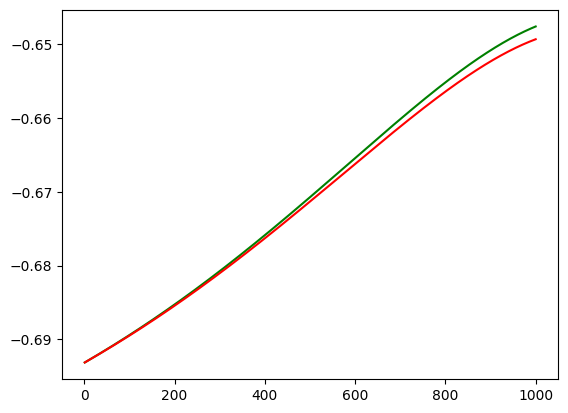

In [75]:
steps_1, errors_1 = model.fit(attributes_train_oversampled,target_train_oversampled,alpha=0.01,epsylon=0.01,max_steps=1000,Rtype="LL", intercept = True, reg = "L2", lam =0.1,  rho = 0)
steps_2, errors_2 = model.fit(attributes_test_oversampled,target_test_oversampled,alpha=0.01,epsylon=0.01,max_steps=1000,Rtype="LL", intercept = True, reg = "L2", lam = 0.1, rho = 0)

_ = plt.plot(steps_1, errors_1, 'g')
_ = plt.plot(steps_2, errors_2, 'r')

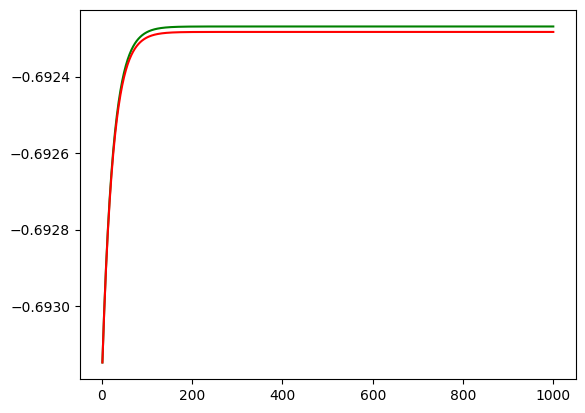

In [76]:
steps_1, errors_1 = model.fit(attributes_train_oversampled,target_train_oversampled,alpha=0.01,epsylon=0.01,max_steps=1000,Rtype="LL", intercept = True, reg = "L2", lam =-2,  rho = 0)
steps_2, errors_2 = model.fit(attributes_test_oversampled,target_test_oversampled,alpha=0.01,epsylon=0.01,max_steps=1000,Rtype="LL", intercept = True, reg = "L2", lam =-2, rho = 0)

_ = plt.plot(steps_1, errors_1, 'g')
_ = plt.plot(steps_2, errors_2, 'r')

In [77]:
acc_train= model.accuracy(attributes_train_oversampled,target_train_oversampled)
acc_test= model.accuracy(attributes_test_oversampled,target_test_oversampled)
print("train:",acc_train)
print("test:",acc_test)
f1 = f1_score(target_train_oversampled, model.predict(attributes_train_oversampled))
print(f"F1 Score train: {f1}")
f1 = f1_score(target_test_oversampled, model.predict(attributes_test_oversampled))
print(f"F1 Score test: {f1}")

train: 0    0.576273
dtype: float64
test: 0    0.575751
dtype: float64
F1 Score train: 0.3944988591463075
F1 Score test: 0.3935281837160751


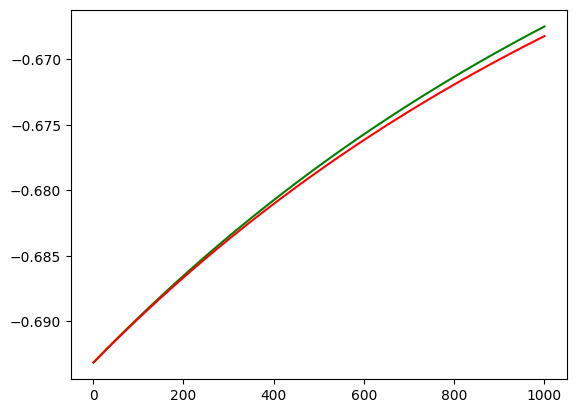

In [78]:
steps_1, errors_1 = model.fit(attributes_train_oversampled,target_train_oversampled,alpha=0.01,epsylon=0.01,max_steps=1000,Rtype="LL", intercept = True, reg = "L2", lam =0.01,  rho = 0)
steps_2, errors_2 = model.fit(attributes_test_oversampled,target_test_oversampled,alpha=0.01,epsylon=0.01,max_steps=1000,Rtype="LL", intercept = True, reg = "L2", lam =0.01, rho = 0)

plt.plot(steps_1, errors_1, 'g')
plt.plot(steps_2, errors_2, 'r')

In [79]:
acc_train= model.accuracy(attributes_train_oversampled,target_train_oversampled)
acc_test= model.accuracy(attributes_test_oversampled,target_test_oversampled)
print("train:",acc_train)
print("test:",acc_test)
f1 = f1_score(target_train_oversampled, model.predict(attributes_train_oversampled))
print(f"F1 Score train: {f1}")
f1 = f1_score(target_test_oversampled, model.predict(attributes_test_oversampled))
print(f"F1 Score test: {f1}")

train: 0    0.594986
dtype: float64
test: 0    0.589216
dtype: float64
F1 Score train: 0.49470398173116636
F1 Score test: 0.48415492957746487


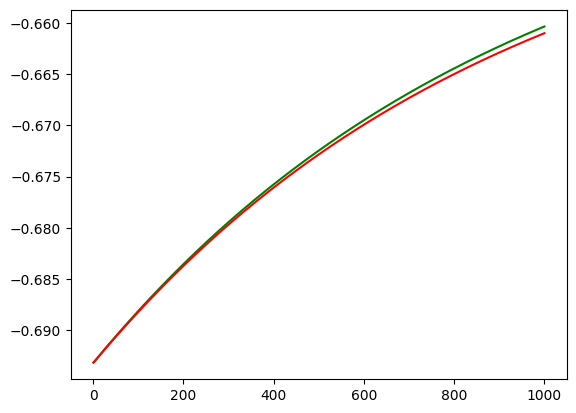

In [80]:
steps_1, errors_1 = model.fit(attributes_train_oversampled,target_train_oversampled,alpha=0.01,epsylon=0.01,max_steps=1000,Rtype="LL", intercept = True, reg = "L1", lam =0.01,  rho = 0)
steps_2, errors_2 = model.fit(attributes_test_oversampled,target_test_oversampled,alpha=0.01,epsylon=0.01,max_steps=1000,Rtype="LL", intercept = True, reg = "L1", lam =0.01, rho = 0)

plt.plot(steps_1, errors_1, 'g')
plt.plot(steps_2, errors_2, 'r')

In [81]:
acc_train= model.accuracy(attributes_train_oversampled,target_train_oversampled)
acc_test= model.accuracy(attributes_test_oversampled,target_test_oversampled)
print("train:",acc_train)
print("test:",acc_test)
f1 = f1_score(target_train_oversampled, model.predict(attributes_train_oversampled))
print(f"F1 Score train: {f1}")
f1 = f1_score(target_test_oversampled, model.predict(attributes_test_oversampled))
print(f"F1 Score test: {f1}")

train: 0    0.597829
dtype: float64
test: 0    0.59002
dtype: float64
F1 Score train: 0.5657106209390835
F1 Score test: 0.5543614572585126


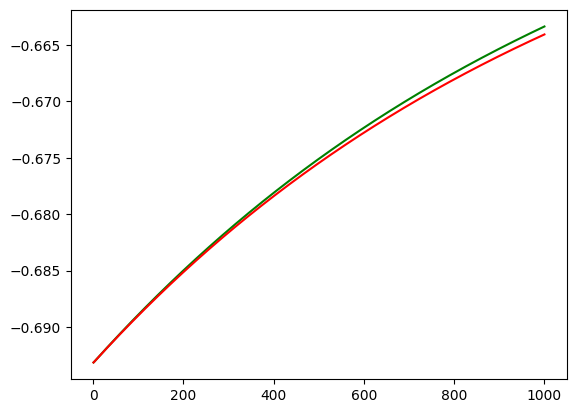

In [82]:
steps_1, errors_1 = model.fit(attributes_train_oversampled,target_train_oversampled,alpha=0.01,epsylon=0.01,max_steps=1000,Rtype="LL", intercept = True, reg = "ElasticNet", lam =1e-2,  rho = 0.5)
steps_2, errors_2 = model.fit(attributes_test_oversampled,target_test_oversampled,alpha=0.01,epsylon=0.01,max_steps=1000,Rtype="LL", intercept = True, reg = "ElasticNet", lam =1e-2, rho = 0.5)

plt.plot(steps_1, errors_1, 'g')
plt.plot(steps_2, errors_2, 'r')

In [83]:
acc_train= model.accuracy(attributes_train_oversampled,target_train_oversampled)
acc_test= model.accuracy(attributes_test_oversampled,target_test_oversampled)
print("train:",acc_train)
print("test:",acc_test)
f1 = f1_score(target_train_oversampled, model.predict(attributes_train_oversampled))
print(f"F1 Score train: {f1}")
f1 = f1_score(target_test_oversampled, model.predict(attributes_test_oversampled))
print(f"F1 Score test: {f1}")

train: 0    0.595701
dtype: float64
test: 0    0.593481
dtype: float64
F1 Score train: 0.5404717508341126
F1 Score test: 0.5367769420222326
